In [8]:
%%capture

import openpyxl
import itertools

if not os.path.exists('ESC-10/Human.xlsx'):
    urllib.urlretrieve('https://github.com/karoldvl/ESC-10/raw/master/ESC-10-HumanClassification.xlsx', 'ESC-10/Human.xlsx')

def pretty_percentage(value):
    return str(int(np.round(value * 1000)) / 10.0) + '%' if (type(value) is float or type(value) is int) else value
    
def convert_to_df(workbook, cell_range, css_classes=['excel'], raw=False):
    shape = np.shape(tuple(workbook.active[cell_range]))
    cells = list(itertools.chain(*tuple(workbook.active[cell_range])))
    values = list(map(lambda c: c.value if '%' not in c.number_format else pretty_percentage(c.value), cells))
    values = list(map(lambda v: v if v is not None else '', values))
    df = pd.DataFrame(np.reshape(values, shape))
    if raw:
        return df
    print("DataFrame:")
    return df.to_html(classes=css_classes, index=False, header=False)
    
workbook_esc10 = openpyxl.load_workbook(filename='ESC-10/Human.xlsx')

In [12]:
import os
import numpy as np
import librosa

class Clip:
    """表示一个5秒长的录音片段。"""

    RATE = 44100   # 所有录音都是44.1 kHz
    FRAME = 512    # 帧大小（以样本为单位）

    class Audio:
        """表示剪辑的实际音频数据。
        
           使用上下文管理器加载/卸载原始音频数据。这样，可以顺序处理剪辑，并且内存使用合理。
        """

        def __init__(self, path):
            self.path = path

        def __enter__(self):
            self.raw, _ = librosa.load(self.path, sr=Clip.RATE, duration=5.0, mono=True)
            return self

        def __exit__(self, exception_type, exception_value, traceback):
            if exception_type is not None:
                print(exception_type, exception_value, traceback)

    def __init__(self, filename):
        self.filename = os.path.basename(filename)
        self.path = os.path.relpath(filename)      
        self.directory = os.path.dirname(self.path)
        self.category = self.directory.split('/')[-1]

        self.audio = Clip.Audio(self.path)

        with self.audio as audio:
            self._compute_mfcc(audio)    
            self._compute_zcr(audio)

    def _compute_mfcc(self, audio):
        # 使用默认设置进行MFCC计算（2048 FFT窗口长度，512跳跃长度，128个频带）
        self.melspectrogram = librosa.feature.melspectrogram(y=audio.raw, sr=Clip.RATE, hop_length=Clip.FRAME, n_fft=2048, n_mels=128)
        self.logamplitude = librosa.power_to_db(self.melspectrogram)
        self.mfcc = librosa.feature.mfcc(S=self.logamplitude, n_mfcc=13).transpose()

    def _compute_zcr(self, audio):
        # 过零率
        self.zcr = librosa.feature.zero_crossing_rate(y=audio.raw, frame_length=Clip.FRAME, hop_length=Clip.FRAME).squeeze()

    def __repr__(self):
        return '<{0}/{1}>'.format(self.category, self.filename)

In [9]:
import IPython
import numpy as np
import pandas as pd
IPython.display.HTML(convert_to_df(workbook_esc10, 'B12:M23', ['excel', 'bottom', 'right', 'diagonal']))

DataFrame:


,Baby cry,Chainsaw,Clock tick,Dog bark,Fire crackling,Helicopter,Person sneeze,Rain,Rooster,Sea waves,Grand Total
Baby cry,508,,,,,,,,,,508
Chainsaw,,459,,,,7,,,1,,467
Clock tick,,,372,,,,,1,,,373
Dog bark,,,,474,,,1,,,,475
Fire crackling,,1,3,1,395,1,,50,,1,452
Helicopter,,23,,1,2,445,,4,,9,484
Person sneeze,2,,,,,,527,,,,529
Rain,,3,,,33,3,,442,,12,493
Rooster,,,,1,,,,,457,,458
Sea waves,,8,,2,,2,,28,,408,448


In [10]:
IPython.display.HTML(convert_to_df(workbook_esc10, 'B46:M56', ['excel', 'right', 'diagonal']))

DataFrame:


,Baby cry,Chainsaw,Clock tick,Dog bark,Fire crackling,Helicopter,Person sneeze,Rain,Rooster,Sea waves,Grand Total
Baby cry,100.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,100.0%
Chainsaw,0.0%,98.3%,0.0%,0.0%,0.0%,1.5%,0.0%,0.0%,0.2%,0.0%,100.0%
Clock tick,0.0%,0.0%,99.7%,0.0%,0.0%,0.0%,0.0%,0.3%,0.0%,0.0%,100.0%
Dog bark,0.0%,0.0%,0.0%,99.8%,0.0%,0.0%,0.2%,0.0%,0.0%,0.0%,100.0%
Fire crackling,0.0%,0.2%,0.7%,0.2%,87.4%,0.2%,0.0%,11.1%,0.0%,0.2%,100.0%
Helicopter,0.0%,4.8%,0.0%,0.2%,0.4%,91.9%,0.0%,0.8%,0.0%,1.9%,100.0%
Person sneeze,0.4%,0.0%,0.0%,0.0%,0.0%,0.0%,99.6%,0.0%,0.0%,0.0%,100.0%
Rain,0.0%,0.6%,0.0%,0.0%,6.7%,0.6%,0.0%,89.7%,0.0%,2.4%,100.0%
Rooster,0.0%,0.0%,0.0%,0.2%,0.0%,0.0%,0.0%,0.0%,99.8%,0.0%,100.0%
Sea waves,0.0%,1.8%,0.0%,0.4%,0.0%,0.4%,0.0%,6.2%,0.0%,91.1%,100.0%


正如预期的那样，人类听众在这个简单任务中表现得很好。对于*ESC-10*数据集，准确的分类率相当高。在所有类别中，我们平均得到了**95.7%的准确率**。对于特定类别的召回率（给定类别的正确响应比例）在87.4%（*crackling fire*）到100%（*crying baby*）之间变化。短而清晰的声音（*baby cry*、*clock tick*、*dog bark*、*sneezing person*、*rooster*）的识别率接近100%。在自然声音背景中（*rain*、*crackling fire*、*sea waves*）存在一些混淆，其召回率下降到90%以下。此外，约有5%的直升机录音被误分类为链锯声。

如果我们深入研究源电子表格并查看个别剪辑的统计信息，会发现一些性能较差的特殊情况：
- 010 - Fire crackling/1-17742-A.ogg $\quad[9 / 15 = 60.0\%]$
- 010 - Fire crackling/5-186924-A.ogg $\quad[10 / 18 = 55.6\%]$
- 010 - Fire crackling/5-213802-A.ogg $\quad[3 / 12 = 25.0\%]$
- 002 - Rain/1-29561-A.ogg $\quad[2 / 4 = 50.0\%]$
- 003 - Sea waves/3-164120-A.ogg $\quad[5 / 14 = 35.7\%]$

为确保它们只是难以而不是不可能识别，我们重新检查这些特定的录音。

In [18]:
IPython.display.Audio(filename='ESC-10/010 - Fire crackling/1-17742-A.ogg', rate=Clip.RATE)
#听起来像小火噼里啪啦的蹦

In [19]:
IPython.display.Audio(filename='ESC-10/010 - Fire crackling/5-186924-A.ogg', rate=Clip.RATE)
#大爆炸声给我吓一跳

In [20]:
IPython.display.Audio(filename='ESC-10/010 - Fire crackling/5-213802-A.ogg', rate=Clip.RATE)
#这个真像发动机启动

In [21]:
IPython.display.Audio(filename='ESC-10/002 - Rain/1-29561-A.ogg', rate=Clip.RATE)
#雨打在铁皮上or打雷的声音

In [22]:
IPython.display.Audio(filename='ESC-10/003 - Sea waves/3-164120-A.ogg', rate=Clip.RATE)
#有点像电锯，很吵

第三个录音确实最难，但在仔细检查时仍然能够在一定程度上识别。我们可以通过上传者提供的原始描述进行验证：

    火炉的近距离录音，燃烧的木材因温度释放蒸汽。

可以预期，在*ESC-50*中我们将会遇到更多类似的难题。

尽管由于使用的程序和样本大小，很难提供硬性统计数据，但从人类的角度来看，对*ESC-10*进行分类被认为是微不足道的。尽管在声景方面存在一些错误的空间，但可以给出一个大致的估计，即对于专注的听众，准确率在**95-100%之间**，在声景方面可能存在一些错误。可以理解的是，这应该会随着50个类别更紧密相关而略有恶化。

此外，还有另一个因素起作用。对于未经训练的参与者来说，类别数量的增加越来越难以掌握。有50个类别时，仍然可以将它们以一种一致的方式呈现（分成5个主要组），而无需使用复杂的嵌套分类法，但这可能已经接近在这种实验设置中“可测试”的边缘。

*ESC-50*数据集的整个混淆矩阵相当庞大，因此我们将集中在个别的召回率数值上。

In [24]:
if not os.path.exists('ESC-50/Human.xlsx'):
    urllib.urlretrieve('https://github.com/karoldvl/ESC-50/raw/master/ESC-50-HumanClassification.xlsx', 'ESC-50/Human.xlsx')
    
workbook_esc50 = openpyxl.load_workbook(filename='ESC-50/Human.xlsx')    
offset = (127, 2)

def results_slice(workbook, first, last):
    results_50 = pd.DataFrame(index=['Recall'])

    for c in range(first, last):
        category_name = workbook.active.cell(row=offset[0] + c, column=offset[1]).value
        recall = pretty_percentage(workbook.active.cell(row=offset[0] + c, column=offset[1] + 1 + c).value)
        results_50 = results_50.join(pd.DataFrame({category_name: recall}, index=['Recall']))
    
    return results_50.to_html(classes='cell_right')

IPython.display.HTML(results_slice(workbook_esc50, 0, 10) + results_slice(workbook_esc50, 10, 20) + results_slice(workbook_esc50, 20, 30)
                     + results_slice(workbook_esc50, 30, 40) + results_slice(workbook_esc50, 40, 50))

,Airplane,Breathing,Brushing teeth,Can opening,Car horn,Cat,Chainsaw,Chirping birds,Church bells,Clapping
Recall,67.9%,89.2%,89.3%,80.5%,89.9%,87.5%,82.7%,84.0%,95.2%,91.9%
,Clock alarm,Clock tick,Coughing,Cow,Crackling fire,Crickets,Crow,Crying baby,Dog,Door - wood creaks
Recall,91.6%,89.5%,93.5%,94.1%,63.4%,51.8%,76.6%,98.7%,100.0%,90.0%
,Door knock,Drinking - sipping,Engine,Fireworks,Footsteps,Frog,Glass breaking,Hand saw,Helicopter,Hen
Recall,89.9%,79.7%,81.7%,68.0%,83.1%,75.3%,98.7%,90.0%,63.9%,76.9%
,Insects (flying),Keyboard typing,Laughing,Mouse click,Pig,Pouring water,Rain,Rooster,Sea waves,Sheep
Recall,98.7%,82.7%,97.3%,65.0%,88.6%,74.7%,77.6%,71.2%,68.0%,94.9%
,Siren,Sneezing,Snoring,Thunderstorm,Toilet flush,Train,Vacuum cleaner,Washing machine,Water drops,Wind
Recall,92.6%,87.5%,84.2%,84.9%,87.7%,66.7%,57.7%,34.2%,92.0%,45.8%


在所有50个类别中，平均准确率为81.3%，每个类别的召回率从100%（狗叫声）到34.1%（洗衣机噪音）不等。在后一种情况中，许多片段被错误分类为直升机声音、怠速发动机或吸尘器声音。

不深入讨论的情况下，*ESC-50*数据集的一般趋势似乎将数据集分为三个难度级别：
- 简单类别（大多数人类声音、动物和一些非常明显的声源，如*警笛*、*水滴*、*玻璃破裂*等），
- 平均类别（介于这两者之间的一切），
- 困难类别（主要是长时间的声音风景和机械噪音）。

经过培训和专注的听众可能仍然可以在这个数据集上获得90%以上的分数，但我们可以预期，即使对于仅有的3/4的情况，使用自动方法获得正确的标签也将变得困难。

In [28]:
def create_set(clips):
    cases = pd.DataFrame()

    for c in range(0, len(clips)):
        for i in range(0, len(clips[c])):
            case = pd.DataFrame([clips[c][i].filename], columns=['filename'])
            case['category'] = c
            case['category_name'] = clips[c][i].category
            case['fold'] = clips[c][i].filename[0]
            
            mfcc_mean = pd.DataFrame(np.mean(clips[c][i].mfcc[:, :], axis=0)[1:]).T
            mfcc_mean.columns = list('MFCC_{} mean'.format(i) for i in range(np.shape(clips[c][i].mfcc)[1]))[1:]
            mfcc_std = pd.DataFrame(np.std(clips[c][i].mfcc[:, :], axis=0)[1:]).T
            mfcc_std.columns = list('MFCC_{} std dev'.format(i) for i in range(np.shape(clips[c][i].mfcc)[1]))[1:]
            case = case.join(mfcc_mean)
            case = case.join(mfcc_std)
            
            case['ZCR mean'] = np.mean(clips[c][i].zcr)
            case['ZCR std dev'] = np.std(clips[c][i].zcr)

            cases = pd.concat([cases, case], ignore_index=True)
    
    cases[['category', 'fold']] = cases[['category', 'fold']].astype(int)
    return cases


In [29]:
def load_dataset(name):
    """Load all dataset recordings into a nested list."""
    clips = []
    
    for directory in sorted(os.listdir('{0}/'.format(name))):
        directory = '{0}/{1}'.format(name, directory)
        if os.path.isdir(directory) and os.path.basename(directory)[0:3].isdigit():
            print('Parsing ' + directory)
            category = []
            for clip in sorted(os.listdir(directory)):
                if clip[-3:] == 'ogg':
                    category.append(Clip('{0}/{1}'.format(directory, clip)))
            clips.append(category)
            
    IPython.display.clear_output()
    print('All {0} recordings loaded.'.format(name))            
    
    return clips

clips_10 = load_dataset('ESC-10')
clips_50 = load_dataset('ESC-50')
cases_10 = create_set(clips_10)
cases_50 = create_set(clips_50)

All ESC-50 recordings loaded.


In [75]:
import sklearn as sk
import sklearn.ensemble

features_start = 'MFCC_1 mean'
features_end = 'ZCR std dev'

def to_percentage(number):
    return int(number * 1000) / 10.0

def classify(cases, classifier='knn', PCA=False, debug=False):
    results = []
    class_count = len(cases['category'].unique())
    confusion = np.zeros((class_count, class_count), dtype=int)
    
    for fold in range(1, 6):
        train = cases[cases['fold'] != fold].copy()
        test = cases[cases['fold'] == fold].copy()
        classifier_name = ''

        if PCA:
            pca = sk.decomposition.PCA()
            pca.fit(train.loc[:, features_start:features_end])
            train.loc[:, features_start:features_end] = pca.transform(train.loc[:, features_start:features_end])
            test.loc[:, features_start:features_end] = pca.transform(test.loc[:, features_start:features_end])

        if classifier == 'knn':
            classifier_name = 'k-NN'
            knn = sk.neighbors.KNeighborsClassifier(n_neighbors=8)
            knn.fit(train.loc[:, features_start:features_end], train['category'])
            test.loc[:, 'prediction'] = knn.predict(test.loc[:, features_start:features_end])
            
        if classifier == 'rf':
            classifier_name = 'Random Forest'
            rf = sk.ensemble.RandomForestClassifier(n_estimators=500, random_state=20150420)
            rf.fit(train.loc[:, features_start:features_end], train['category'])
            test.loc[:, 'prediction'] = rf.predict(test.loc[:, features_start:features_end])
            
        if classifier == 'svm':
            classifier_name = 'Support Vector Machine (SVM)'
            svm = sk.svm.SVC(C=0.1, kernel='linear', random_state=20150420)
            svm.fit(train.loc[:, features_start:features_end], train['category'])
            test.loc[:, 'prediction'] = svm.predict(test.loc[:, features_start:features_end])

        accuracy = np.sum(test['category'] == test['prediction']) / float(len(test['category']))
        results.append(accuracy)
        confusion_current = sk.metrics.confusion_matrix(test['category'], test['prediction'])
        confusion = confusion + confusion_current
        
        print('Classifying fold {0} with {1} classifier. Accuracy: {2}%'.format(fold, classifier_name, to_percentage(accuracy)))
        if debug:
            print('Confusion matrix:\n', confusion_current, '\n')
        
    print('Average accuracy: {0}%\n'.format(to_percentage(np.mean(results))))
    return confusion, results

def pretty_confusion(confusion_matrix, cases, mode='recall', css_classes=['diagonal', 'cell_right'], raw=False):
    if mode == 'recall':
        confusion_matrix = confusion_matrix * 1000 / np.sum(confusion_matrix, axis=1) / 10.0
        confusion_matrix = np.vectorize(lambda x: '{0}%'.format(x))(confusion_matrix)

    show_headers = False if 'draggable' in css_classes else True
        
    categories = sorted(cases['category'].unique())
    labels = []
    
    for c in categories:
        category_subset = cases[cases['category'] == c]
        if not category_subset.empty:
            label = category_subset['category_name'].values[0][6:]
            labels.append(label)
        else:
            print(f"Category {c} not found in cases DataFrame.")

    labels = list(map(lambda x: x if x else 'Unknown', labels))
    
    confusion_matrix = pd.DataFrame(confusion_matrix, index=labels, columns=labels)
    
    if raw:
        return confusion_matrix    
    else:
        return IPython.display.HTML(confusion_matrix.to_html(classes=css_classes, header=show_headers))


In [76]:
confusion_10_knn, accuracy_10_knn = classify(cases_10, 'knn')
confusion_10_rf, accuracy_10_rf = classify(cases_10, 'rf')
confusion_10_svm, accuracy_10_svm = classify(cases_10, 'svm')

Classifying fold 1 with k-NN classifier. Accuracy: 57.5%
Classifying fold 2 with k-NN classifier. Accuracy: 72.5%
Classifying fold 3 with k-NN classifier. Accuracy: 66.2%
Classifying fold 4 with k-NN classifier. Accuracy: 72.5%
Classifying fold 5 with k-NN classifier. Accuracy: 62.5%
Average accuracy: 66.2%

Classifying fold 1 with Random Forest classifier. Accuracy: 62.5%
Classifying fold 2 with Random Forest classifier. Accuracy: 76.2%
Classifying fold 3 with Random Forest classifier. Accuracy: 77.5%
Classifying fold 4 with Random Forest classifier. Accuracy: 76.2%
Classifying fold 5 with Random Forest classifier. Accuracy: 72.5%
Average accuracy: 73.0%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 57.5%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 78.7%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 65.0%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 76.2%
Classifying

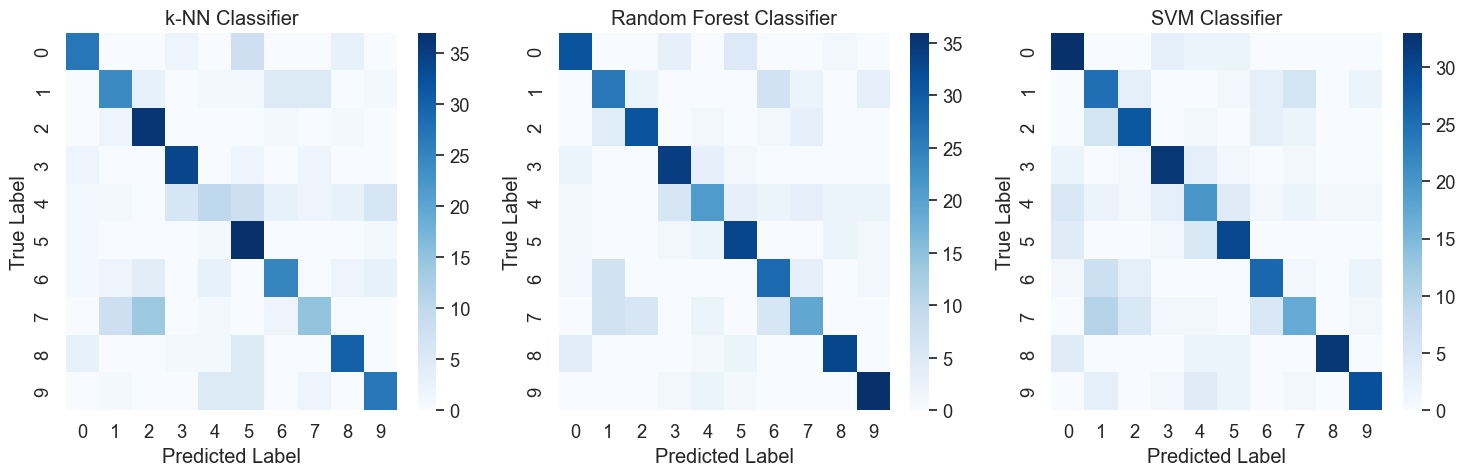

In [62]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(confusion_10_knn, cmap='Blues')
plt.title('k-NN Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(1, 3, 2)
sns.heatmap(confusion_10_rf, cmap='Blues')
plt.title('Random Forest Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(1, 3, 3)
sns.heatmap(confusion_10_svm, cmap='Blues')
plt.title('SVM Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()  # 使得子图不重叠
plt.show()

在*ESC-10*数据集上进行的5折交叉验证显示，**k-NN**分类器的平均准确率为**66.7%**，**SVM**为**67.5%**，而使用**随机森林**集成则为**72.7%**。各个折叠之间存在一些显著的差异，第一个折叠的验证准确率对所有分类器都低于60%。

这在这样小的折叠中是可以预期的（我们有400个片段，因此5折设置会将其分为320个片段用于训练和80个片段用于验证）。解决这个问题的一种方法可能是通过合并一些折叠来增加每个实验的验证集大小，但这将减少训练案例的数量，这也是不可取的。总体上，对于这么小的数据集，这是一个困难的问题。

观察*随机森林*分类器的混淆矩阵（左侧 - *实际*，顶部 - *预测*，对角线上是召回率） - 大多数类别的真正例率接近80%，*rooster*和*crackling fire*的分类准确率分别达到85%和87.5%。与人类在这项任务中的能力进行比较是很有趣的。在机器学习分类器设置中表现最好的后一类别（*fire crackling*），实际上是人类参与者中最困难的，人类和机器在识别这种类型的声音事件方面取得了类似的结果。

我们选择的机器分类器在回忆*ticking clocks*（47.5%）方面表现非常糟糕，而这对于大多数人来说是一项简单的任务，因为它具有非常特殊的定期时间模式。这是我们使用简单模型丢失大量信息的示例，应该使用更复杂的方法（如顺序/状态转换模型、计算增量或其他依赖时间的特征等）。

链锯声也带来了很多问题。如果回想基于PCA的[类别分离图](#plot_PCA)，我们会发现链锯声与其他类别有很多重叠，并且在整个空间中分散。

总结这个分析，我们可以说总体性能令人满意，考虑到我们使用的是非常基础的方法。在这种情况下最明显的缺陷可能是对于人类参与者来说很容易的非常特殊声音的性能不佳（*barking dog*、*crying baby*等）。从人类的角度来看，一个良好的声音识别系统应该努力实现对于这些声音的近乎完全的召回，因为它们为语义价值（前景声音）提供了很多，与大多数声音景观相比，这些声音会自然地被过滤掉，作为噪声/背景（不那么重要）信息。

另一件值得注意的事情是，正如这些结果所显示的，*ESC-10*确实提供了一个简化的问题。使用基线方法达到70%的准确度，我们可以期望更精细的方法在这个数据集上达到接近人类（90%以上）的性能。然而，解决这种简单任务可能会带来一些有用的见解。

*ESC-50*在这方面应该更具挑战性，也给了更多的改进空间，尽管它仍然远离大规模声音检索。让我们看看在将40个额外类别添加到数据集时情况会如何变化。

In [77]:
confusion_50_knn, accuracy_50_knn = classify(cases_50, 'knn')
confusion_50_rf, accuracy_50_rf = classify(cases_50, 'rf')
confusion_50_svm, accuracy_50_svm = classify(cases_50, 'svm')

Classifying fold 1 with k-NN classifier. Accuracy: 29.2%
Classifying fold 2 with k-NN classifier. Accuracy: 31.2%
Classifying fold 3 with k-NN classifier. Accuracy: 32.5%
Classifying fold 4 with k-NN classifier. Accuracy: 33.2%
Classifying fold 5 with k-NN classifier. Accuracy: 27.7%
Average accuracy: 30.8%

Classifying fold 1 with Random Forest classifier. Accuracy: 40.7%
Classifying fold 2 with Random Forest classifier. Accuracy: 44.0%
Classifying fold 3 with Random Forest classifier. Accuracy: 42.5%
Classifying fold 4 with Random Forest classifier. Accuracy: 42.2%
Classifying fold 5 with Random Forest classifier. Accuracy: 40.0%
Average accuracy: 41.8%

Classifying fold 1 with Support Vector Machine (SVM) classifier. Accuracy: 36.2%
Classifying fold 2 with Support Vector Machine (SVM) classifier. Accuracy: 37.0%
Classifying fold 3 with Support Vector Machine (SVM) classifier. Accuracy: 36.0%
Classifying fold 4 with Support Vector Machine (SVM) classifier. Accuracy: 39.0%
Classifying

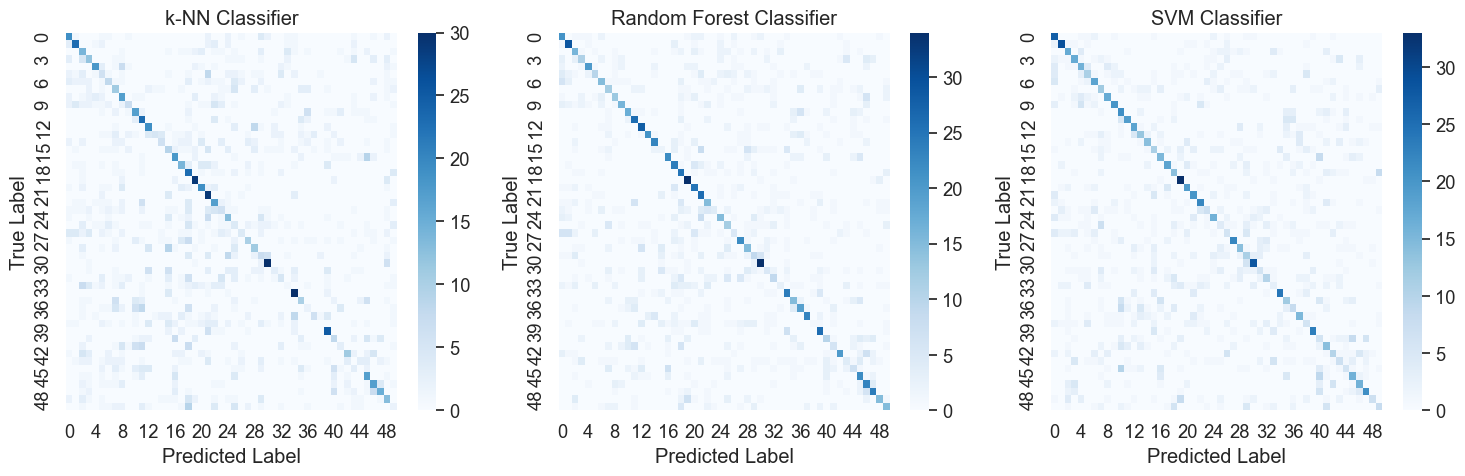

In [64]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(confusion_50_knn, cmap='Blues')
plt.title('k-NN Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(1, 3, 2)
sns.heatmap(confusion_50_rf, cmap='Blues')
plt.title('Random Forest Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(1, 3, 3)
sns.heatmap(confusion_50_svm, cmap='Blues')
plt.title('SVM Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()  # 使得子图不重叠
plt.show()

在处理50个类别时，平均准确率降至低40%，其中**k-NN**表现最差（**30.8%**），**SVM**在中间，各折之间相对稳定，为**37.3%**，**random forest**为 **41.8%**
。

*原始实验在论文中报告的SVM（39.6%）、random forest（44.3%）、k-NN（32.2%）的结果略有不同，这很可能是由于一些最近的软件包更改。不幸的是，我无法确定可能导致这种差异的确切问题*。
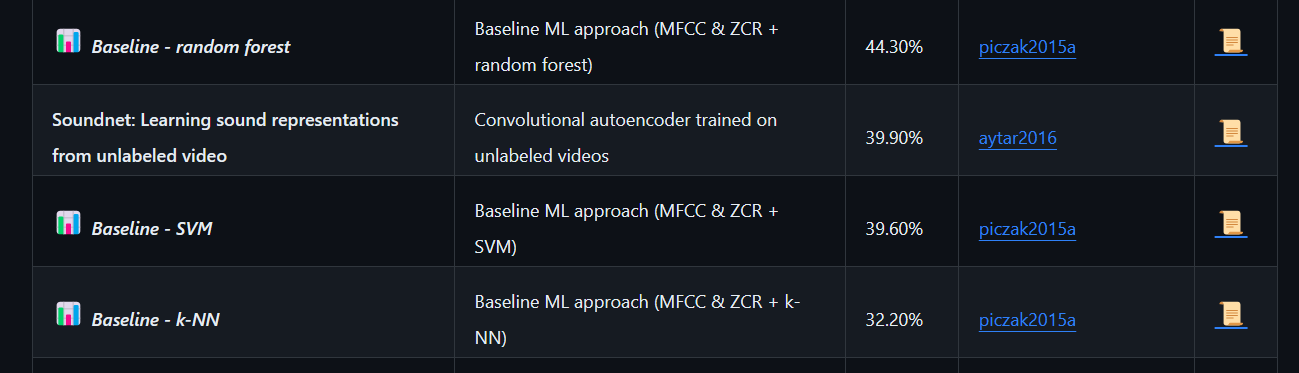

让我们可视化跨数据集的结果，以便更容易进行比较。

meta NOT subset; don't know how to subset; dropped


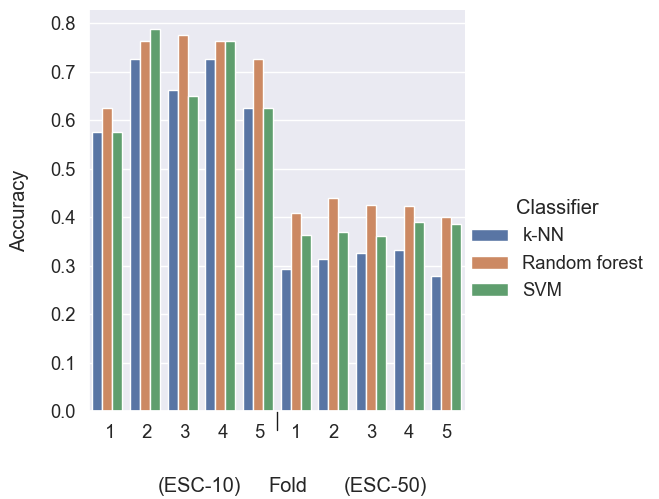

In [89]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
def plot_accuracy_folds(knn_10, rf_10, svm_10, knn_50, rf_50, svm_50):
    def plot_line(start, end):
        line = ax.add_line(matplotlib.lines.Line2D(start, end, color='k', linewidth=1))
        line.set_clip_on(False)
        
    folds_10 = list(map(lambda i: ' %d' % i, range(1, 6)))
    folds_50 = list(map(lambda i: '%d' % i, range(1, 6)))
    accuracy = pd.DataFrame({'Fold': folds_10, 'Accuracy': knn_10, 'Classifier': 'k-NN'})
    accuracy = pd.concat([accuracy, pd.DataFrame({'Fold': folds_10, 'Accuracy': rf_10, 'Classifier': 'Random forest'})])
    accuracy = pd.concat([accuracy, pd.DataFrame({'Fold': folds_10, 'Accuracy': svm_10, 'Classifier': 'SVM'})])
    accuracy = pd.concat([accuracy, pd.DataFrame({'Fold': folds_50, 'Accuracy': knn_50, 'Classifier': 'k-NN'})])
    accuracy = pd.concat([accuracy, pd.DataFrame({'Fold': folds_50, 'Accuracy': rf_50, 'Classifier': 'Random forest'})])
    accuracy = pd.concat([accuracy, pd.DataFrame({'Fold': folds_50, 'Accuracy': svm_50, 'Classifier': 'SVM'})])
    sb.catplot(x='Fold', y='Accuracy', hue='Classifier', data=accuracy, kind='bar', hue_order=['k-NN', 'Random forest', 'SVM'])



    ax = plt.gca()
    ax.set_xlabel(' ', labelpad=20)
    ax.set_ylabel('Accuracy', labelpad=15)
    ax.annotate('(ESC-10)', xy=(0, 0), xytext=(0.23, 0.015), textcoords='figure fraction')
    ax.annotate('Fold', xy=(0, 0), xytext=(0.39, 0.015), textcoords='figure fraction')
    ax.annotate('(ESC-50)', xy=(0, 0), xytext=(0.5, 0.015), textcoords='figure fraction')
    plot_line((4.5, 4.5), (0.00, -0.04))
    
plot_accuracy_folds(accuracy_10_knn, accuracy_10_rf, accuracy_10_svm, accuracy_50_knn, accuracy_50_rf, accuracy_50_svm)

plt.savefig("figure_accuracy_folds.pdf")